In [2]:
# Subscriber Lookalike Analysis (calibrated propensity + optional similarity)

# load libraries and turn off warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import random



# set seed
random.seed(42)

# load data
query_2 = pd.read_csv('df.csv')


In [3]:
query_2.head()

,USER_ID,AS_OF_DATE,CREATED_DATE,DAYS_SINCE_CREATED,IS_ACTIVE,DAYS_SINCE_LAST_ACTIVE,IS_IN_FREE_TRIAL_NOW,IS_PAYING_SUBSCRIBER_NOW,IS_SUBSCRIBER_NOW,MONTHLY_SUBSCRIBER_STATUS,...,FIRST_TRIAL_TS,HAS_TRIALED,N_SHARED_PLANS_OWNED,SEATS_NOW_TOTAL,NON_OWNER_SEATS_NOW_TOTAL,MEMBERS_WITH_PAID_SUB_NOW_TOTAL,FIRST_SHARED_PLAN_TS,CURRENT_PROCESSOR,CURRENT_PRICING_GROUP,CURRENT_GC_APP
0,359ea7fc-1092-4acb-beb9-a69b37394ac0,2025-08-28,2023-08-16,743,True,1,False,False,False,inactive,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d91ec3f7-0c3e-49e7-81d8-e13bd11ac7a4,2025-08-28,2020-09-26,1797,True,1,False,True,True,retained,...,2022-07-04 00:41:45.670,True,NaN,NaN,NaN,NaN,NaN,google,2022.0,Team Manager
2,9a2d9219-5fc0-4700-944b-7fcdf20251bb,2025-08-28,2023-03-21,891,False,1,False,False,False,inactive,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,247e0027-3392-4024-bfb7-14de6b710b83,2025-08-28,2020-06-01,1914,False,1,False,False,False,inactive,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e64ad19b-5275-49bf-8eaa-a0d319b21e47,2025-08-28,2019-06-22,2259,False,19,False,True,True,retained,...,2022-02-12 18:53:19.000,True,NaN,NaN,NaN,NaN,NaN,apple,2025.0,Team Manager


In [ ]:
# set up our functions

# the goal is to combine random forest classification with logistic regression so that we get the best of both methods
# we're going to create a few functions here to define and clean
class SubscriberLookalikeAnalysis:
    def __init__(self, df):
        self.df = df.copy()
        self.features = None
        self.target = None
        self.scaler = StandardScaler()
        self.rf_model = None          # calibrated RF
        self.lr_model = None          # calibrated LR
        self.rf_aux_for_importance = None
        self.feature_importance = None
        self.eval_metrics = {}
        self.lift_df = None
        self.test_index_mask = None   # indices for test split
        self.ensemble_probs_all = None

    # set up a feature engineering function and add a lil tracker so we know where we are in the process
    def prepare_features(self):
      print("Starting feature engineering...")

      self.df['is_subscriber_target'] = self.df['is_subscriber_now'].astype(int)

      # ratios, recency scores
      self.df['engagement_per_team'] = self.df['n_teams_interacted'] / (self.df['n_teams'] + 1)
      self.df['content_per_team'] = (
            self.df['n_livestreams_viewed']
          + self.df['n_archived_videos_viewed']
      ) / (self.df['n_teams'] + 1)
      dsl = self.df['days_since_last_active'].fillna(999)
      self.df['activity_recency_score'] = np.select(
          condlist   = [dsl.eq(0), dsl.le(7), dsl.le(30)]
        , choicelist = [10, 5, 2]
        , default    = 1
      )

      # engagement intensity
      self.df['total_content_viewed'] = (
            self.df['n_livestreams_viewed']
          + self.df['n_archived_videos_viewed']
          + self.df['n_film_review_videos_viewed']
      )
      self.df['total_stats_viewed'] = (
            self.df['n_play_by_plays_viewed']
          + self.df['n_player_stats_viewed']
          + self.df['n_box_scores_viewed']
      )

      # team roles depth
      self.df['total_roles'] = (
            self.df['n_staff_roles']
          + self.df['n_family_roles']
          + self.df['n_fan_roles']
          + self.df['n_player_roles']
      )
      self.df['current_roles'] = (
            self.df['n_current_staff_roles']
          + self.df['n_current_family_roles']
          + self.df['n_current_fan_roles']
          + self.df['n_current_player_roles']
      )

      # account maturity
      self.df['account_age_weeks'] = self.df['days_since_created'] / 7.0
      self.df['is_new_user'] = (self.df['days_since_created'] <= 30).astype(int)

      # coverage producer rollup
      self.df['is_any_coverage_producer'] = (
            self.df['is_successful_coverage_producer'].astype(int)
          | self.df['is_successful_scoring_coverage_producer'].astype(int)
          | self.df['is_successful_streaming_coverage_producer'].astype(int)
      ).astype(int)

      feature_columns = [
          # engagement flags
          'is_active','is_engaged','is_super_engaged'
        , 'is_team_management_engaged','is_team_management_super_engaged'
        , 'is_free_feature_engaged','is_free_feature_super_engaged'
        , 'is_paid_feature_engaged','is_paid_feature_super_engaged'
        , 'is_coverage_producer_engaged','is_coverage_producer_super_engaged'
          # content
        , 'n_livestreams_viewed','n_archived_videos_viewed','n_film_review_videos_viewed'
        , 'total_content_viewed','n_seconds_livestreams_viewed','n_seconds_archived_videos_viewed'
          # stats
        , 'n_play_by_plays_viewed','n_player_stats_viewed','n_box_scores_viewed'
        , 'n_spray_charts_viewed','n_animated_gamestreams_viewed','total_stats_viewed'
          # teams & roles
        , 'n_teams','n_current_teams','n_teams_interacted','total_roles','current_roles'
        , 'n_rec_teams','n_club_teams','n_school_teams'
          # activity
        , 'n_games_streamed_60_days','n_games_scored_60_days','n_games_covered_60_days'
        , 'n_messages_sent','n_events_created','n_events_rsvpd','n_users_invited'
          # coverage
        , 'is_any_coverage_producer'
          # account
        , 'days_since_created','account_age_weeks','is_new_user'
        , 'activity_recency_score','engagement_per_team','content_per_team'
          # trial
        , 'has_trialed'
      ]

      # one-hots: sport
      if 'primary_sport_daily' in self.df.columns:
          sport_dummies = pd.get_dummies(
                self.df['primary_sport_daily']
              , prefix    = 'sport'
              , dummy_na  = True
          )
          self.df = pd.concat([self.df, sport_dummies], axis = 1)
          feature_columns.extend(sport_dummies.columns.tolist())

      # one-hots: competition level (DAILY)
      if 'primary_competition_daily' in self.df.columns:
          comp_dummies = pd.get_dummies(
                self.df['primary_competition_daily']
              , prefix    = 'comp'
              , dummy_na  = True
          )
          self.df = pd.concat([self.df, comp_dummies], axis = 1)
          feature_columns.extend(comp_dummies.columns.tolist())

      # one-hots: age group (SELF)
      if 'self_age_group_condensed' in self.df.columns:
          age_dummies = pd.get_dummies(
                self.df['self_age_group_condensed']
              , prefix    = 'age'
              , dummy_na  = True
          )
          self.df = pd.concat([self.df, age_dummies], axis = 1)
          feature_columns.extend(age_dummies.columns.tolist())

      # top-10 states as binary flags
      if 'primary_state' in self.df.columns:
          top_states = self.df['primary_state'].value_counts().head(10).index
          for st in top_states:
              col = f'state_{st}'
              self.df[col] = (self.df['primary_state'] == st).astype(int)
              feature_columns.append(col)

      available = [c for c in feature_columns if c in self.df.columns]
      self.features = self.df[available].fillna(0)
      self.target   = self.df['is_subscriber_target']

      print(f"Feature engineering complete. Using {len(available)} features.")
      return self.features , self.target


    # lift table for assessment
    @staticmethod
    def lift_table(scores, y, bins = 10):
        df = pd.DataFrame({'s': scores, 'y': y}).sort_values('s', ascending = False)
        df['decile'] = pd.qcut(df['s'], bins, labels = False, duplicates = 'drop')
        agg = df.groupby('decile').agg(
              pos_rate = ('y','mean')
            , count    = ('y','size')
        ).sort_index(ascending = False).reset_index(drop = True)
        overall = df['y'].mean()
        agg['lift'] = agg['pos_rate'] / (overall + 1e-9)
        return agg , overall

    # training!
    def train_propensity_models(
        self
      , test_size = 0.2
      , random_state = 42
      , cutoff_date = None        # e.g., '2025-06-30' for time-based split
    ):
        print("Training propensity models (calibrated)...")

        X = self.features
        y = self.target.values

        if cutoff_date is not None and 'as_of_date' in self.df.columns:
            cutoff = pd.to_datetime(cutoff_date)
            mask_tr = pd.to_datetime(self.df['as_of_date']) <= cutoff
            X_train , X_test = X[mask_tr] , X[~mask_tr]
            y_train , y_test = y[mask_tr] , y[~mask_tr]
            self.test_index_mask = (~mask_tr).values
            print(f"Time-based split with cutoff {cutoff_date}: train={mask_tr.sum():,} test={(~mask_tr).sum():,}")
        else:
            X_train , X_test , y_train , y_test = train_test_split(
                  X , y
                , test_size = test_size
                , stratify  = y
                , random_state = random_state
            )
            # store test mask (approximate) for plotting convenience
            self.test_index_mask = np.zeros(len(self.df), dtype = bool)
            self.test_index_mask[self.test_index_mask.shape[0] - len(y_test):] = True

        # scale only for LR
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled  = self.scaler.transform(X_test)

        # calibrated RF (unscaled)
        self.rf_model = CalibratedClassifierCV(
              RandomForestClassifier(
                    n_estimators = 300
                  , max_depth = 12
                  , min_samples_leaf = 10
                  , class_weight = 'balanced'
                  , n_jobs = -1
                  , random_state = random_state
                )
            , method = 'isotonic'
            , cv = 3
        )
        self.rf_model.fit(X_train, y_train)

        # auxiliary RF for importances (faster than permutation on large data)
        self.rf_aux_for_importance = RandomForestClassifier(
              n_estimators = 300
            , max_depth = 12
            , min_samples_leaf = 10
            , class_weight = 'balanced'
            , n_jobs = -1
            , random_state = random_state
        ).fit(X_train, y_train)
        self.feature_importance = pd.DataFrame(
              dict(
                    feature = X_train.columns
                  , rf_importance = self.rf_aux_for_importance.feature_importances_
              )
        ).sort_values('rf_importance', ascending = False)

        # calibrated LR (scaled)
        self.lr_model = CalibratedClassifierCV(
              LogisticRegression(
                    penalty = 'l2'
                  , C = 1.0
                  , class_weight = 'balanced'
                  , max_iter = 500
                  , solver = 'lbfgs'
                  , n_jobs = None
                  , random_state = random_state
                )
            , method = 'isotonic'
            , cv = 3
        )
        self.lr_model.fit(X_train_scaled, y_train)

        # evaluation
        rf_p = self.rf_model.predict_proba(X_test)[:, 1]
        lr_p = self.lr_model.predict_proba(X_test_scaled)[:, 1]
        ens  = 0.6 * rf_p + 0.4 * lr_p

        roc  = float(roc_auc_score(y_test, ens))
        pr   = float(average_precision_score(y_test, ens))
        lift , base = self.lift_table(ens, y_test, bins = 10)

        self.eval_metrics = dict(
              roc_auc = roc
            , pr_auc  = pr
            , base_rate = float(base)
            , n_train = int(len(y_train))
            , n_test  = int(len(y_test))
        )
        self.lift_df = lift

        print(f"AUC-ROC: {roc:.3f} | PR-AUC: {pr:.3f} | Base rate: {base:.3f}")
        return (X_train, X_test, y_train, y_test)

    # create a faster similarity funciton for when weight is set to zero 
    def similarity_to_subscribers_fast(
      self
    , n_estimators = 200
    , max_depth    = 16
    , random_state = 42
  ):
      # fast unsupervised leaf-sharing similarity to current subscribers
      X = self.features.values.astype(np.float32)
      n , m = X.shape
      rng = np.random.default_rng(random_state)

      # column-wise permutation synthetic class
      X_synth = np.vstack([rng.permutation(X[:, j]) for j in range(m)]).T
      X_all   = np.vstack([X, X_synth])
      y_all   = np.concatenate([np.ones(n, np.int8), np.zeros(n, np.int8)])

      rf = RandomForestClassifier(
            n_estimators   = n_estimators
          , max_depth      = max_depth
          , min_samples_leaf = 5
          , max_features   = 'sqrt'
          , bootstrap      = True
          , max_samples    = 0.6
          , n_jobs         = -1
          , random_state   = random_state
      ).fit(X_all, y_all)

      leaves   = rf.apply(X)  # (n, trees)
      sub_mask = self.df['is_subscriber_now'].astype(int).values == 1
      if sub_mask.sum() == 0:
          return np.zeros(n, dtype = float)

      accum = np.zeros(n, dtype = float)
      for t in range(leaves.shape[1]):
          lt = leaves[:, t]
          uniq , inv = np.unique(lt, return_inverse = True)
          counts = np.bincount(inv[sub_mask], minlength = uniq.size)
          accum += counts[inv]
      return accum / (leaves.shape[1] * sub_mask.sum())


    # rank our results 
    def identify_lookalikes(
        self
      , top_n = 1000
      , sim_weight = 0.0   # set a weight to blend our models, 0 means pure propensity score weight, 1 means pure similarity; anything between 0.1–0.3 will pull prospects toward dense subscriber neighborhoods
    ):
        print("Identifying subscriber lookalikes...")

        # propensity everywhere for ranking later
        rf_probs = self.rf_model.predict_proba(self.features)[:, 1]
        lr_probs = self.lr_model.predict_proba(self.scaler.transform(self.features))[:, 1]
        ensemble = 0.6 * rf_probs + 0.4 * lr_probs

        if sim_weight > 0.0:
            sim = self.similarity_to_subscribers_fast()
            ensemble = (1 - sim_weight) * ensemble + sim_weight * sim

        self.ensemble_probs_all = ensemble

        results = pd.DataFrame(
              dict(
                    user_id = self.df['user_id'].values
                  , is_subscriber = self.df['is_subscriber_now'].astype(int).values
                  , rf_propensity = rf_probs
                  , lr_propensity = lr_probs
                  , ensemble_propensity = ensemble
                  , is_active = self.df['is_active'].values
                  , days_since_created = self.df['days_since_created'].values
                  , n_teams = self.df['n_teams'].values
                  , is_engaged = self.df['is_engaged'].values
              )
        )

        non_subs = results[results['is_subscriber'] == 0].copy()
        non_subs['propensity_rank'] = non_subs['ensemble_propensity'].rank(ascending = False, method = 'first')

        quality = non_subs[
              (non_subs['is_active'] == 1)
            & (non_subs['days_since_created'] >= 7)
            & (non_subs['n_teams'] > 0)
        ].copy()

        top_prospects = quality.nsmallest(top_n, 'propensity_rank')
        print(f"Identified {len(top_prospects)} high-quality prospects | Avg prop: {top_prospects['ensemble_propensity'].mean():.3f}")
        return top_prospects , results

    # create an insights data frame to summarize key findings for top figures
    def generate_insights(self, top_prospects):
        print("\nGenerating insights...")
        subscribers = self.df[self.df['is_subscriber_now'] == 1]
        metrics = [
            'n_current_teams','is_engaged','is_super_engaged'
          , 'n_livestreams_viewed','account_age_weeks','total_content_viewed'
        ]
        insights = {}
        ids = set(top_prospects['user_id'])
        for m in metrics:
            if m in self.df.columns:
                prospect_avg  = self.df[self.df['user_id'].isin(ids)][m].mean()
                subscriber_avg = subscribers[m].mean()
                insights[m] = dict(
                      prospect_avg    = float(prospect_avg)
                    , subscriber_avg  = float(subscriber_avg)
                    , similarity_ratio = float(prospect_avg / (subscriber_avg + 1e-9))
                )
        return insights

    # adding this in to avoid having to tinker later on, but let's viz some of our output
    def plot_results(self, results, top_prospects):
        fig , axes = plt.subplots(2, 2, figsize = (15, 12))

        # propensity distributions
        ns_mask = results['is_subscriber'] == 0
        s_mask  = ~ns_mask
        axes[0,0].hist(results.loc[ns_mask, 'ensemble_propensity'], bins = 50, alpha = 0.7, density = True, label = 'Non-subs')
        axes[0,0].hist(results.loc[s_mask,  'ensemble_propensity'], bins = 50, alpha = 0.7, density = True, label = 'Subs')
        axes[0,0].axvline(top_prospects['ensemble_propensity'].min(), linestyle = '--', label = 'Prospect threshold')
        axes[0,0].set_title('Propensity Distribution'); axes[0,0].legend()

        # top RF features
        topF = self.feature_importance.head(15)
        axes[0,1].barh(range(len(topF)), topF['rf_importance'].values)
        axes[0,1].set_yticks(range(len(topF))); axes[0,1].set_yticklabels(topF['feature'].values)
        axes[0,1].invert_yaxis(); axes[0,1].set_title('Top Feature Importances (RF)')

        # propsects by competition level
        if 'primary_competition_daily' in self.df.columns:
            # latest row per user to avoid duplicates
            tmp = (
                self.df.sort_values('as_of_date')
                      .groupby('user_id', as_index = False)
                      .tail(1)
            )
            prospect_ids = set(top_prospects['user_id'])
            p = tmp[tmp['user_id'].isin(prospect_ids)].copy()

            comp_counts = (
                p['primary_competition_daily']
                  .fillna('unknown')
                  .value_counts()
                  .sort_values(ascending = False)
            )
            axes[1,0].bar(comp_counts.index, comp_counts.values)
            axes[1,0].set_xlabel('Competition Level')
            axes[1,0].set_ylabel('Top Prospect Count')
            axes[1,0].set_title('Top Prospects by Competition Level')
            axes[1,0].tick_params(axis = 'x', rotation = 20)

            # sandbox stacked by age group 
            # if 'self_age_group_condensed' in p.columns:
            #     comp_age = (p.assign(
            #                   comp = p['primary_competition_daily'].fillna('unknown')
            #                 , age  = p['self_age_group_condensed'].fillna('unknown'))
            #                 .groupby(['comp','age']).size().unstack(fill_value = 0)
            #               )
            #     axes[1,0].clear()
            #     bottom = np.zeros(len(comp_age))
            #     for age in comp_age.columns:
            #         axes[1,0].bar(comp_age.index, comp_age[age].values, bottom = bottom, label = str(age))
            #         bottom += comp_age[age].values
            #     axes[1,0].set_xlabel('Competition Level')
            #     axes[1,0].set_ylabel('Top Prospect Count')
            #     axes[1,0].set_title('Top Prospects by Competition Level (stacked by Age Group)')
            #     axes[1,0].legend(fontsize = 8)
        else:
            axes[1,0].text(0.5, 0.5, 'primary_competition_daily not found', ha = 'center')

        # ROC for the nerds (I'm the nerds)
        if self.test_index_mask is not None and self.ensemble_probs_all is not None:
            test_mask = self.test_index_mask
            y_test_all = self.df['is_subscriber_now'].astype(int).values[test_mask]
            s_test_all = self.ensemble_probs_all[test_mask]
            if y_test_all.size > 0:
                from sklearn.metrics import roc_curve
                fpr , tpr , _ = roc_curve(y_test_all, s_test_all)
                axes[1,1].plot(fpr, tpr, label = 'Ensemble ROC')
                axes[1,1].plot([0,1],[0,1],'k--', alpha = 0.5)
                axes[1,1].set_title('ROC Curve'); axes[1,1].legend()

        plt.tight_layout()
        return fig

# running function
def run_subscriber_lookalike_analysis(
    query_2
  , top_n = 1000
  , cutoff_date = None     # e.g., '2025-06-30' for time-based split
  , sim_weight = 0.0       # set to e.g. 0.2 to blend in similarity
):
    analysis = SubscriberLookalikeAnalysis(query_2)

    features , target = analysis.prepare_features()
    X_train , X_test , y_train , y_test = analysis.train_propensity_models(
          test_size = 0.2
        , random_state = 42
        , cutoff_date = cutoff_date
    )

    top_prospects , results = analysis.identify_lookalikes(
          top_n = top_n
        , sim_weight = sim_weight
    )
    insights = analysis.generate_insights(top_prospects)
    fig = analysis.plot_results(results, top_prospects)

    print("\n" + "="*50)
    print("SUBSCRIBER LOOKALIKE ANALYSIS SUMMARY")
    print("="*50)
    print(f"Total users analyzed: {len(query_2):,}")
    print(f"Current subscribers: {int(target.sum()):,} ({target.mean()*100:.1f}%)")
    print(f"High-quality prospects identified: {len(top_prospects):,}")
    print(f"Average prospect propensity: {top_prospects['ensemble_propensity'].mean():.3f}")
    print(f"Top prospect propensity: {top_prospects['ensemble_propensity'].max():.3f}")
    print("\nEval:", analysis.eval_metrics)
    print("\nLift table (deciles):")
    print(analysis.lift_df.to_string(index = True))

    print("\nTop 10 Feature Importances:")
    print(analysis.feature_importance.head(10)[['feature','rf_importance']].to_string(index = False))

    return top_prospects , analysis , insights


Starting feature engineering...
Feature engineering complete. Using 90 features.
Training propensity models (calibrated)...
AUC-ROC: 0.943 | PR-AUC: 0.763 | Base rate: 0.174
Identifying subscriber lookalikes...
Identified 500000 high-quality prospects | Avg prop: 0.099

Generating insights...

SUBSCRIBER LOOKALIKE ANALYSIS SUMMARY
Total users analyzed: 7,243,531
Current subscribers: 1,261,236 (17.4%)
High-quality prospects identified: 500,000
Average prospect propensity: 0.099
Top prospect propensity: 0.522

Eval: {'roc_auc': 0.9433590122277016, 'pr_auc': 0.7629870700371888, 'base_rate': 0.17411871413612276, 'n_train': 5794824, 'n_test': 1448707}

Lift table (deciles):
   pos_rate   count      lift
0  0.792912  144871  4.553860
1  0.516022  144864  2.963621
2  0.346404  144877  1.989471
3  0.051777  144871  0.297367
4  0.015089  144870  0.086662
5  0.010078  144865  0.057882
6  0.004494  144852  0.025811
7  0.002353  144895  0.013516
8  0.001383  144654  0.007941
9  0.000682  145088  0

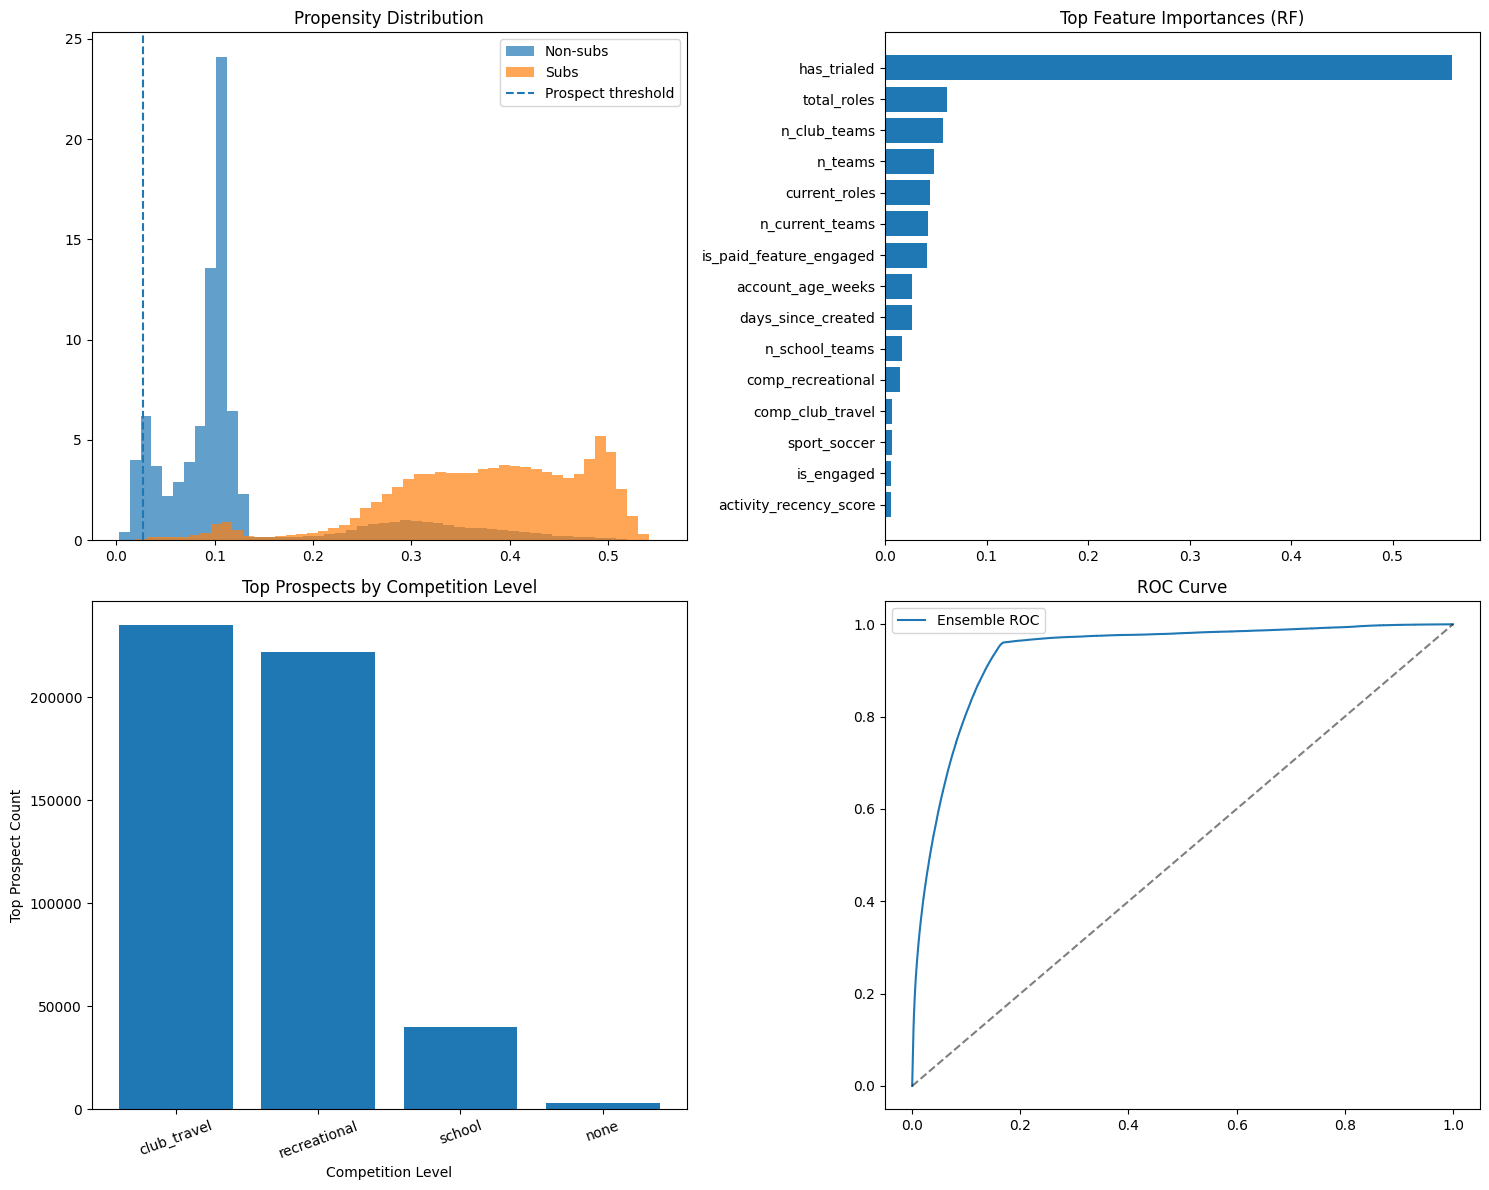

In [5]:
# normalize column names
query_2 = query_2.copy()
query_2.columns = [str(c).lower() for c in query_2.columns]

# run the analysis

top_prospects , analysis , insights = run_subscriber_lookalike_analysis(
    query_2
  , top_n = 500000
  , cutoff_date = None   
  , sim_weight = 0.5
)





In [6]:
def insights_per_user_latest(
    analysis
  , top_prospects
  , metrics = (
        'days_since_last_active'
      , 'n_current_teams'
      , 'is_engaged'
      , 'is_super_engaged'
      , 'n_livestreams_viewed'
      , 'days_since_created'
      , 'total_content_viewed'
    )
):
    tmp = analysis.df.assign(
        propensity = analysis.ensemble_probs_all
    )
    latest = (
        tmp.sort_values('as_of_date')
           .groupby('user_id', as_index = False)
           .tail(1)
    )

    prospect_ids = set(top_prospects['user_id'])
    prospects     = latest[latest['user_id'].isin(prospect_ids)]
    subscribers   = latest[latest['is_subscriber_now'].astype(int) == 1]

    rows = []
    for m in metrics:
        if m in latest.columns:
            p_avg = prospects[m].mean()
            s_avg = subscribers[m].mean()
            rows.append(
                dict(
                    metric = m
                  , prospect_avg = float(p_avg)
                  , subscriber_avg = float(s_avg)
                  , similarity_ratio = float(p_avg / (s_avg + 1e-9))
                  , diff = float(p_avg - s_avg)
                )
            )
    return pd.DataFrame(rows).sort_values('similarity_ratio', ascending = False)

# run it
insights_df_latest = insights_per_user_latest(analysis, top_prospects)
insights_df_latest



,metric,prospect_avg,subscriber_avg,similarity_ratio,diff
2,is_engaged,0.619018,0.356201,1.737832,0.262817
4,n_livestreams_viewed,0.010234,0.008270,1.237535,0.001964
3,is_super_engaged,0.106658,0.089484,1.191927,0.017174
6,total_content_viewed,0.014650,0.016117,0.908993,-0.001467
1,n_current_teams,7.118956,10.814400,0.658285,-3.695444
5,days_since_created,1020.540902,1580.127186,0.645860,-559.586284
0,days_since_last_active,7.350320,37.778218,0.194565,-30.427898
